### Integrating VADER Sentiment into LSTM Stock Prediction Model on a Weekly Basis

### References

1. **VADER Sentiment Analysis**
   - Tutorial: [Python Sentiment Analysis using VADER](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)
     - Reference: [GeeksforGeeks](https://www.geeksforgeeks.org/). "Python Sentiment Analysis using VADER."

2. **LSTM Stock Price Prediction**
   - Tutorial: [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
     - Reference: Jason Brownlee. "Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras." *Machine Learning Mastery*.

3. **Time Series Data Analysis**
   - Tutorial: [Working with Time Series Data](https://machinelearningmastery.com/time-series-data-visualization-with-python/)
     - Reference: Jason Brownlee. "Time Series Data Visualization with Python." *Machine Learning Mastery*.

4. **Linear Regression**
   - Tutorial: [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)
     - Reference: [Real Python](https://realpython.com/). "Linear Regression in Python."


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from utils.StockPricesProcess import load_prices_df, add_lags

# defining the path to the stock prices data and the date range
df_path = "../data/stock_prices/yfinance/AAPL_prices_2016-01-01_2020-01-01.csv"
start_date_string = "2016-01-01"
end_date_string = "2020-01-01"

# Load stock prices and add lags using functions from StockPricesProcess.py
stock_data = load_prices_df(path=df_path, start_date_string=start_date_string, end_date_string=end_date_string)
stock_data = add_lags(stock_data=stock_data.copy(), numLags=3)
stock_data["Date"] = stock_data.index

stock_data = stock_data.resample("W-Fri", on="Date").last()



In [2]:
stock_twits = pd.read_csv("../data/stocktwits/stocktwits_AAPL.csv")
stock_twits["Date"] = pd.to_datetime(stock_twits["datetime"], utc=True)

start_date = pd.to_datetime(start_date_string, utc=True)
end_date = pd.to_datetime(end_date_string, utc=True)
# Filtering stock_twits DataFrame to include only rows within the specified date range
stock_twits = stock_twits.loc[(stock_twits["Date"] >= start_date) & (stock_twits["Date"] <= end_date)]

print("Minimum Date:", stock_twits["Date"].min())
print("Maximum Date:", stock_twits["Date"].max())
stock_twits.shape

Minimum Date: 2016-01-01 00:00:06+00:00
Maximum Date: 2019-12-31 23:57:46+00:00


(650894, 6)

In [3]:
import sys
sys.path.append('../..')
from utils.SentimentAnalysis import preprocess_text

# Applying preprocess_text function to the stock_twits messages
stock_twits["processed_message"] = stock_twits["message"].apply(preprocess_text)

c:\Users\omare\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from utils.SentimentAnalysis import get_vader_sentiment_score 


stock_twits["sentiment_score"] = stock_twits["processed_message"].apply(get_vader_sentiment_score)

In [5]:
tweets_aggregated_score = stock_twits.groupby("Date")["sentiment_score"].mean().reset_index()


In [6]:
tweets_aggregated_score.set_index("Date", inplace=True)
tweets_aggregated_score.index = pd.DatetimeIndex(tweets_aggregated_score.index)

In [7]:
weekly_sentiment_scores = tweets_aggregated_score.resample('W-Fri').mean()
weekly_sentiment_scores.head()

,sentiment_score
Date,
2016-01-01 00:00:00+00:00,0.147081
2016-01-08 00:00:00+00:00,0.069165
2016-01-15 00:00:00+00:00,0.083733
2016-01-22 00:00:00+00:00,0.085857
2016-01-29 00:00:00+00:00,0.088500


In [8]:
stock_data.reset_index(inplace=True)
weekly_sentiment_scores.reset_index(inplace=True)

In [9]:
stock_data.head(2)

,Date,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3
0,2016-01-08 00:00:00+00:00,22.401223,22.528516,21.994342,22.039803,283192000,21.923868,22.889933,23.346827
1,2016-01-15 00:00:00+00:00,21.867051,22.210287,21.676113,22.078447,319335600,22.621714,22.137545,22.721733


In [10]:
weekly_sentiment_scores.head(2)

,Date,sentiment_score
0,2016-01-01 00:00:00+00:00,0.147081
1,2016-01-08 00:00:00+00:00,0.069165


In [11]:
# stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date
# weekly_sentiment_scores['Date'] = weekly_sentiment_scores.index
# weekly_sentiment_scores.reset_index(drop=True, inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date
weekly_sentiment_scores['Date'] = pd.to_datetime(weekly_sentiment_scores['Date'], utc=True).dt.date

# Merging stock_data and tweets_aggregated_score DataFrames based on the 'Date' column, using left join
merged_data = pd.merge(stock_data, weekly_sentiment_scores, on="Date", how="left")
merged_data.set_index("Date", inplace=True)

nan_values = merged_data.isna().sum()

merged_data.head()

,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,sentiment_score
Date,,,,,,,,,
2016-01-08,22.401223,22.528516,21.994342,22.039803,283192000,21.923868,22.889933,23.346827,0.069165
2016-01-15,21.867051,22.210287,21.676113,22.078447,319335600,22.621714,22.137545,22.721733,0.083733
2016-01-22,22.419408,23.062691,22.360309,23.053598,263202000,21.889778,22.001162,21.971615,0.085857
2016-01-29,21.546548,22.126183,21.446531,22.126183,257666000,21.387430,21.235134,22.728546,0.088500
2016-02-05,22.058832,22.150249,21.412061,21.487478,185672400,22.077120,21.901150,21.476084,0.116363


In [12]:
from sklearn.preprocessing import MinMaxScaler


# Selecting 'Close' column as features and 'Close' column as target from the merged_data DataFrame
features = merged_data[['Close']]  # Features
target = merged_data['Close']  # Target variable

# Scaling the features using MinMaxScaler with feature range (0, 1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scaling the target variable using MinMaxScaler with feature range (0, 1)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Concatenating the scaled features and scaled target variable along the columns axis
scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Dense

# Splitting the scaled_data into train_data and test_data using an 80-20 split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences for training LSTM model
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length, -1] 
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 2  # Length of sequences to be used for training
# Creating sequences and labels for training and testing data
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Defining the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_test, y_test))

# Making predictions using the trained model on test data
predictions = model.predict(X_test)

# Inverse transforming the predicted values to original scale
predictions = scaler_target.inverse_transform(predictions)
# Inverse transforming the true target values to original scale
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))



Epoch 1/100

55/55 [==============================] - 2s 7ms/step - loss: 0.0308 - val_loss: 0.0202
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0083
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 4/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 

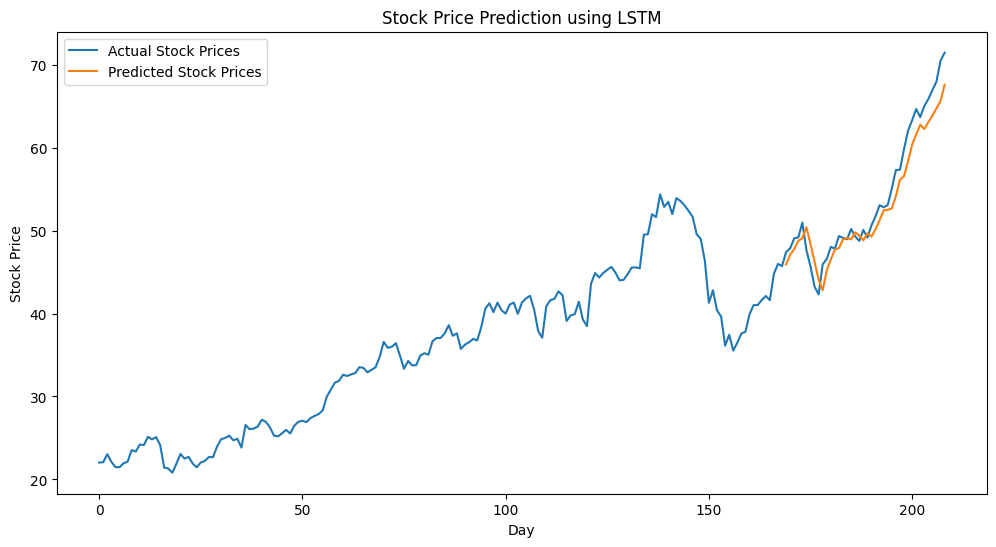

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'].values, label='Actual Stock Prices')
plt.plot(np.arange(train_size + sequence_length, len(stock_data)), predictions, label='Predicted Stock Prices')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Importing evaluation metrics from sklearn

# Inverse transforming the true target values to their original scale
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculating mean squared error (MSE) between actual and predicted values
mse = mean_squared_error(y_test_actual, predictions)

# Calculating root mean squared error (RMSE) from MSE
rmse = np.sqrt(mse)

# Calculating mean absolute error (MAE) between actual and predicted values
mae = mean_absolute_error(y_test_actual, predictions)

# Calculating R-squared (R²) score between actual and predicted values
r2 = r2_score(y_test_actual, predictions)

# Printing the evaluation results
print(f'Results without including Sentiment Scores')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Results without including Sentiment Scores
Mean Squared Error (MSE): 4.950647492023563
Root Mean Squared Error (RMSE): 2.225005054381577
Mean Absolute Error (MAE): 1.8787612915039062
R-squared (R²): 0.9208884033492776


In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



features = merged_data[['Close','sentiment_score']] 
target = merged_data['Close']

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

In [17]:


train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_sequences(merged_data, sequence_length):
    sequences, labels = [], []
    for i in range(len(merged_data) - sequence_length):
        seq = merged_data[i:i+sequence_length]
        label = merged_data[i+sequence_length, -1] 
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 2 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_test, y_test))



predictions = model.predict(X_test)

predictions = scaler_target.inverse_transform(predictions)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))



Epoch 1/100
55/55 [==============================] - 1s 7ms/step - loss: 0.0241 - val_loss: 0.0321
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 4/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 7/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 11/

55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.9558e-04
Epoch 19/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 20/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 21/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 22/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.8886e-04
Epoch 23/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 24/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 25/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 26/100
55/55 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 27/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch

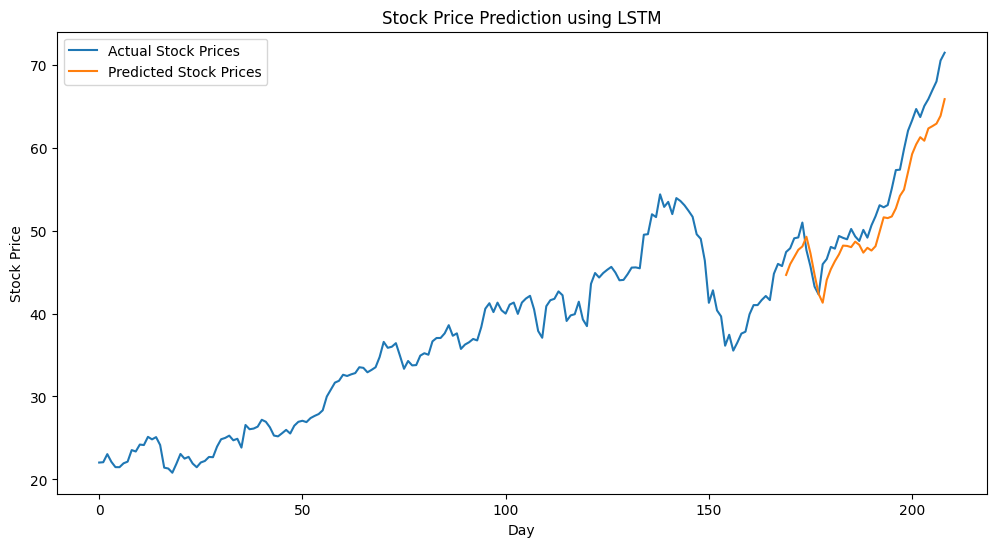

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'].values, label='Actual Stock Prices')
plt.plot(np.arange(train_size + sequence_length, len(stock_data)), predictions, label='Predicted Stock Prices')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 10.278987210782725
Root Mean Squared Error (RMSE): 3.206085964346983
Mean Absolute Error (MAE): 2.8095610618591316
R-squared (R²): 0.8357412658631872


In [20]:
merged_data.head()

,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,sentiment_score
Date,,,,,,,,,
2016-01-08,22.401223,22.528516,21.994342,22.039803,283192000,21.923868,22.889933,23.346827,0.069165
2016-01-15,21.867051,22.210287,21.676113,22.078447,319335600,22.621714,22.137545,22.721733,0.083733
2016-01-22,22.419408,23.062691,22.360309,23.053598,263202000,21.889778,22.001162,21.971615,0.085857
2016-01-29,21.546548,22.126183,21.446531,22.126183,257666000,21.387430,21.235134,22.728546,0.088500
2016-02-05,22.058832,22.150249,21.412061,21.487478,185672400,22.077120,21.901150,21.476084,0.116363


In [21]:
from sklearn.model_selection import train_test_split

# Define features and target for the model without sentiment
features_without_sentiment = merged_data[["Close_Lag1", "Close_Lag2", "Close_Lag3", "Volume" ]]
target_without_sentiment = merged_data['Close']

features_with_sentiment = merged_data[["Close_Lag1", "Close_Lag2", "Close_Lag3", "Volume", "sentiment_score" ]]
target_with_sentiment = merged_data['Close']

# Split the data
X_train_without_sentiment, X_test_without_sentiment, y_train_without_sentiment, y_test_without_sentiment = train_test_split(
    features_without_sentiment, target_without_sentiment, test_size=0.2, random_state=42
)

X_train_with_sentiment, X_test_with_sentiment, y_train_with_sentiment, y_test_with_sentiment = train_test_split(
    features_with_sentiment, target_without_sentiment, test_size=0.2, random_state=42
)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model without sentiment
model_without_sentiment = LinearRegression()
model_without_sentiment.fit(X_train_without_sentiment, y_train_without_sentiment)

# Model with sentiment
model_with_sentiment = LinearRegression()
model_with_sentiment.fit(X_train_with_sentiment, y_train_with_sentiment)

LinearRegression()

In [23]:
from sklearn.metrics import mean_squared_error

# Predictions without sentiment
predictions_without_sentiment = model_without_sentiment.predict(X_test_without_sentiment)
mse_without_sentiment = mean_squared_error(y_test_without_sentiment, predictions_without_sentiment)
mae_without_sentiment = mean_absolute_error(y_test_without_sentiment, predictions_without_sentiment)
r2_without_sentiment = r2_score(y_test_without_sentiment, predictions_without_sentiment)

# Predictions with sentiment
predictions_with_sentiment = model_with_sentiment.predict(X_test_with_sentiment)
mse_with_sentiment = mean_squared_error(y_test_with_sentiment, predictions_with_sentiment)
mae_with_sentiment = mean_absolute_error(y_test_with_sentiment, predictions_with_sentiment)
r2_with_sentiment = r2_score(y_test_with_sentiment, predictions_with_sentiment)


print(f'Mean Squared Error without Sentiment: {mse_without_sentiment}')
print(f'Mean Squared Error with Sentiment: {mse_with_sentiment}')
print("==============================================")
print(f'Mean Absolute Error without Sentiment: {mae_without_sentiment}')
print(f'Mean Absolute Error with Sentiment: {mae_with_sentiment}')
print("==============================================")
print(f'R-squared without Sentiment: {r2_without_sentiment}')
print(f'R-squared with Sentiment: {r2_with_sentiment}')

Mean Squared Error without Sentiment: 0.6044339165165058
Mean Squared Error with Sentiment: 0.5668321250477771
Mean Absolute Error without Sentiment: 0.500674641601421
Mean Absolute Error with Sentiment: 0.47865094739185005
R-squared without Sentiment: 0.9957512097393513
R-squared with Sentiment: 0.9960155266828743


In [24]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression

# Model without sentiment
model_without_sentiment = LinearRegression()

# Perform cross-validation
cv_scores_without_sentiment = cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                             scoring='neg_mean_squared_error', cv=5)
cv_mse_without_sentiment = -cv_scores_without_sentiment
cv_rmse_without_sentiment = np.sqrt(cv_mse_without_sentiment)
cv_mae_without_sentiment = -cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                            scoring='neg_mean_absolute_error', cv=5)
cv_r2_without_sentiment = cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                          scoring='r2', cv=5)

# Model with sentiment
model_with_sentiment = LinearRegression()

# Perform cross-validation
cv_scores_with_sentiment = cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                           scoring='neg_mean_squared_error', cv=5)
cv_mse_with_sentiment = -cv_scores_with_sentiment
cv_rmse_with_sentiment = np.sqrt(cv_mse_with_sentiment)
cv_mae_with_sentiment = -cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                          scoring='neg_mean_absolute_error', cv=5)
cv_r2_with_sentiment = cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                       scoring='r2', cv=5)

print("Linear Regression Model without Sentiment:")
print(f"Mean and Standard Deviation of MSE across 5 folds: {np.mean(cv_mse_without_sentiment):.4f} ± {np.std(cv_mse_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of RMSE across 5 folds: {np.mean(cv_rmse_without_sentiment):.4f} ± {np.std(cv_rmse_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of MAE across 5 folds: {np.mean(cv_mae_without_sentiment):.4f} ± {np.std(cv_mae_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of R-squared across 5 folds: {np.mean(cv_r2_without_sentiment):.4f} ± {np.std(cv_r2_without_sentiment):.4f}")
print()

print("Linear Regression Model with Sentiment:")
print(f"Mean and Standard Deviation of MSE across 5 folds: {np.mean(cv_mse_with_sentiment):.4f} ± {np.std(cv_mse_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of RMSE across 5 folds: {np.mean(cv_rmse_with_sentiment):.4f} ± {np.std(cv_rmse_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of MAE across 5 folds: {np.mean(cv_mae_with_sentiment):.4f} ± {np.std(cv_mae_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of R-squared across 5 folds: {np.mean(cv_r2_with_sentiment):.4f} ± {np.std(cv_r2_with_sentiment):.4f}")


Linear Regression Model without Sentiment:
Mean and Standard Deviation of MSE across 5 folds: 0.4637 ± 0.3106
Mean and Standard Deviation of RMSE across 5 folds: 0.6347 ± 0.2466
Mean and Standard Deviation of MAE across 5 folds: 0.4550 ± 0.1805
Mean and Standard Deviation of R-squared across 5 folds: 0.9641 ± 0.0263

Linear Regression Model with Sentiment:
Mean and Standard Deviation of MSE across 5 folds: 0.4309 ± 0.2939
Mean and Standard Deviation of RMSE across 5 folds: 0.6121 ± 0.2371
Mean and Standard Deviation of MAE across 5 folds: 0.4482 ± 0.1752
Mean and Standard Deviation of R-squared across 5 folds: 0.9681 ± 0.0222


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Assuming 'merged_data' is your dataset

features = merged_data[['Close']]
target = merged_data['Close']

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length, :-1]  # Exclude the target variable from the sequences
        label = data[i+sequence_length, -1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 1
# Define the number of folds for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize metrics for evaluation
mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=3)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate model performance
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)
    r2 = r2_score(y_test_actual, predictions)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')
    print()



mean_mse = round(np.mean(mse_scores), 4)
std_mse = round(np.std(mse_scores), 4)

mean_rmse = round(np.mean(rmse_scores), 4)
std_rmse = round(np.std(rmse_scores), 4)

mean_mae = round(np.mean(mae_scores), 4)
std_mae = round(np.std(mae_scores), 4)

mean_r2 = round(np.mean(r2_scores), 4)
std_r2 = round(np.std(r2_scores), 4)

print('LSTM without including Sentiment')
print(f'Mean and Standard Deviation of MSE across {n_splits} folds: {mean_mse} ± {std_mse}')
print(f'Mean and Standard Deviation of RMSE across {n_splits} folds: {mean_rmse} ± {std_rmse}')
print(f'Mean and Standard Deviation of MAE across {n_splits} folds: {mean_mae} ± {std_mae}')
print(f'Mean and Standard Deviation of R-squared across {n_splits} folds: {mean_r2} ± {std_r2}')

Epoch 1/100


56/56 [==============================] - 1s 1ms/step - loss: 0.1191
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 4/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0229
Epoch 5/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 6/100
56/56 [==============================] - 0s 933us/step - loss: 0.0142
Epoch 7/100
56/56 [==============================] - 0s 997us/step - loss: 0.0094
Epoch 8/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 9/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 10/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 11/100
56/56 [==============================] - 0s 988us/step - loss: 0.0030
Epoch 12/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 13/100
56/56 [=======================

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Assuming 'merged_data' is your dataset

features = merged_data[['Close', 'sentiment_score']]
target = merged_data['Close']

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)



# Define the number of folds for K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize metrics for evaluation
mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=3)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)
    r2 = r2_score(y_test_actual, predictions)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)


mean_mse = round(np.mean(mse_scores), 4)
std_mse = round(np.std(mse_scores), 4)

mean_rmse = round(np.mean(rmse_scores), 4)
std_rmse = round(np.std(rmse_scores), 4)

mean_mae = round(np.mean(mae_scores), 4)
std_mae = round(np.std(mae_scores), 4)

mean_r2 = round(np.mean(r2_scores), 4)
std_r2 = round(np.std(r2_scores), 4)

print('LSTM including Sentiment')
print(f'Mean and Standard Deviation of MSE across {n_splits} folds: {mean_mse} ± {std_mse}')
print(f'Mean and Standard Deviation of RMSE across {n_splits} folds: {mean_rmse} ± {std_rmse}')
print(f'Mean and Standard Deviation of MAE across {n_splits} folds: {mean_mae} ± {std_mae}')
print(f'Mean and Standard Deviation of R-squared across {n_splits} folds: {mean_r2} ± {std_r2}')

Epoch 1/100


56/56 [==============================] - 1s 1ms/step - loss: 0.1111
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 4/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0212
Epoch 5/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 6/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 7/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 8/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 9/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 10/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 11/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 12/100
56/56 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 13/100
56/56 [=============================